# **Use keras to count Sea Lions**

This kernel is a lite version of my approach.

[for more information...][1]


  [1]: https://www.kaggle.com/c/noaa-fisheries-steller-sea-lion-population-count/discussion/35408

In [48]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

%matplotlib inline

**Scale and patch**

In [2]:
r = 0.48     #scale down
width = 300 #patch size 
batch_size = 2

**Get dot coordinates and cut image to patches :** (thanks to Radu Stoicescu)

In [14]:
def GetData(directory):
    trainX = []
    trainY = []
    list_num = np.random.choice(948, 10, replace=False)
    for i in list_num:
        # read the Train and Train Dotted images
        image_1 = cv2.imread("./TrainDotted/" + str(i) + '.jpg')
        image_2 = cv2.imread("./Train/" + str(i) + '.jpg')
        img1 = cv2.GaussianBlur(image_1,(5,5),0)
        if image_1.shape != image_2.shape:
            print(i)
            plt.imshow(image_1)
            plt.imshow(image_2)
            image_2 = np.rot90(image_2, k=3)


        # absolute difference between Train and Train Dotted
        image_3 = cv2.absdiff(image_1,image_2)
        mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
        mask_1[mask_1 < 50] = 0
        mask_1[mask_1 > 0] = 255
        image_4 = cv2.bitwise_or(image_3, image_3, mask=mask_1)

        # convert to grayscale to be accepted by skimage.feature.blob_log
        image_6 = np.max(image_4,axis=2)

        # detect blobs
        blobs = skimage.feature.blob_log(image_6, min_sigma=3, max_sigma=7, num_sigma=1, threshold=0.05)

        h,w,d = image_2.shape

        res=np.zeros((int((w*r)//width)+1,int((h*r)//width)+1,5), dtype='int16')

        for blob in blobs:
            # get the coordinates for each blob
            y, x, s = blob
            # get the color of the pixel from Train Dotted in the center of the blob
            b,g,R = img1[int(y)][int(x)][:]
            x1 = int((x*r)//width)
            y1 = int((y*r)//width)
            # decision tree to pick the class of the blob by looking at the color in Train Dotted
            if R > 225 and b < 25 and g < 25: # RED
                res[x1,y1,0]+=1
            elif R > 225 and b > 225 and g < 25: # MAGENTA
                res[x1,y1,1]+=1
            elif R < 75 and b < 50 and 150 < g < 200: # GREEN
                res[x1,y1,4]+=1
            elif R < 75 and  150 < b < 200 and g < 75: # BLUE
                res[x1,y1,3]+=1
            elif 60 < R < 120 and b < 50 and g < 75:  # BROWN
                res[x1,y1,2]+=1

        ma = cv2.cvtColor((1*(np.sum(image_1, axis=2)>20)).astype('uint8'), cv2.COLOR_GRAY2BGR)
        img = cv2.resize(image_2 * ma, (int(w*r),int(h*r)))
        h1,w1,d = img.shape


        for i in range(int(w1//width)):
            for j in range(int(h1//width)):
                trainY.append(res[i,j,:])
                trainX.append(img[j*width:j*width+width,i*width:i*width+width,:])

    return np.array(trainX), np.array(trainY)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

**Use only 1 image, split to train/test.**

In my real approach:

 - r = 1 to 0.6561 (0.9^0, 0.9^1 ... 0.9^4)
   
 - patch size = 300x300
   
 - cut whole training set to patches, number of positive(all) vs
   background(random) = 1 : 3
   
 - 95% for training, 5% for validation

 - data augmentation by flip, rotate, change saturation, brightness, contrast

In [15]:
trainX, trainY = GetData("./Train")

np.random.seed(1004)
randomize = np.arange(len(trainX))
np.random.shuffle(randomize)
trainX = trainX[randomize]
trainY = trainY[randomize]

n_train = int(len(trainX) * 0.95)
valX = trainX[n_train:]
valY = trainY[n_train:]
trainX = trainX[:n_train]
trainY = trainY[:n_train]

print(trainY.shape, trainY[0])
print(valY.shape, valY[0])

(342, 5) [0 0 8 0 0]
(18, 5) [0 0 0 0 0]


In [16]:
from imgaug import augmenters as iaa

augmentation = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # vertical flips

    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    #iaa.MultiplySaturation((0.5, 1.5)),
    iaa.Multiply((0.8, 1.2), per_channel=0),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        rotate=(-90, 90))
    ], random_order=True) # apply augmenters in random order

# def additional_augmenation(image):
#     image = aug1.augment_image(image)
#     image = aug2.augment_image(image)
#     return image

In [17]:

augmentation.show_grid([trainX[0], trainX[1]], cols=4, rows=4)

In [56]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, decode_predictions

# preprocessing image and divide validaiton set
train_datagen=ImageDataGenerator(preprocessing_function=augmentation.augment_image)
validation_datagen=ImageDataGenerator()

train_generator=train_datagen.flow(trainX, 
                                   trainY,
                                   batch_size=batch_size,
                                   shuffle=True)


validation_generator = validation_datagen.flow(valX, 
                                   valY,
                                   batch_size=batch_size)

**Patches looks like :**

[[0 0 8 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]]


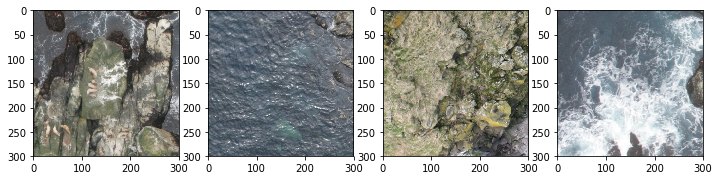

In [34]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    ax = fig.add_subplot(1,4,i+1)
    plt.imshow(cv2.cvtColor(trainX[i], cv2.COLOR_BGR2RGB))
print(trainY[:4])

**Keras CNN model, for example**

In [57]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU

# Transfer Learning from VGG16 architecture
# Without fully-connected layers
# define input shape as (224,224,3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300,300,3))

# Define our own fully-connected layers & output layer
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation=LeakyReLU(alpha=0.1))(x)
# x = Dropout(0.3)(x)

preds = Dense(5, activation='linear')(x) #final layer with softmax activation



model = Model(inputs=base_model.input, outputs=preds)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

/usr/local/lib/python3.5/dist-packages/keras/activations.py:186: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [58]:
for layer in model.layers[:-3]:
    layer.trainable = False
for layer in model.layers[-3:]:
    layer.trainable = True
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

full version model:

    initial_model = applications.VGG16(weights="imagenet", include_top=False, input_shape=(300,300,3))
    last = initial_model.output
    x = Flatten()(last)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=.1)(x)
    preds = Dense(5, activation='linear')(x)
    model = Model(initial_model.input, preds)

**Start training slowly :**

58 training epochs is a example in the kernel. I train the new FC several epochs, observe the loss, then train more layers until the train loss close to 0.3. The total epochs before training the whole network is about 60(I think it is too slow due to my poor skill). And the whole network takes 27 epochs to got 0.126/0.247 train/validation loss with private LB 11.7.
 - 60 epoch before whole layers

In [ ]:
import keras.callbakcs import ReduceLROnPlateau

callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)]

In [60]:
optim = keras.optimizers.SGD(lr=1e-4, momentum=0.2)
model.compile(loss='mean_squared_error', optimizer=optim)


step_size_train = train_generator.n // train_generator.batch_size
step_size_val = validation_generator.n // validation_generator.batch_size

history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
                              validation_data=validation_generator, validation_steps=step_size_val,
                              epochs=60, verbose=2)


Epoch 1/60
 - 5s - loss: 20.4783 - val_loss: 7.0560
Epoch 2/60
 - 3s - loss: 7.0379 - val_loss: 4.7193
Epoch 3/60
 - 3s - loss: 6.6296 - val_loss: 5.5031
Epoch 4/60
 - 4s - loss: 6.0456 - val_loss: 5.7313
Epoch 5/60
 - 4s - loss: 5.5416 - val_loss: 4.7518
Epoch 6/60
 - 4s - loss: 5.3124 - val_loss: 5.3840
Epoch 7/60
 - 4s - loss: 4.5663 - val_loss: 5.0829
Epoch 8/60
 - 4s - loss: 5.0559 - val_loss: 4.1816
Epoch 9/60
 - 4s - loss: 5.2710 - val_loss: 4.4068
Epoch 10/60
 - 4s - loss: 4.6892 - val_loss: 4.1588
Epoch 11/60
 - 4s - loss: 4.7706 - val_loss: 3.8196
Epoch 12/60
 - 4s - loss: 4.1255 - val_loss: 5.6645
Epoch 13/60
 - 4s - loss: 3.7454 - val_loss: 4.2713
Epoch 14/60
 - 4s - loss: 4.0754 - val_loss: 4.9050
Epoch 15/60
 - 4s - loss: 3.9021 - val_loss: 4.7849
Epoch 16/60
 - 4s - loss: 3.2627 - val_loss: 5.0733
Epoch 17/60
 - 4s - loss: 3.3824 - val_loss: 5.1346
Epoch 18/60
 - 4s - loss: 2.8450 - val_loss: 4.0299
Epoch 19/60
 - 4s - loss: 4.1456 - val_loss: 5.2197
Epoch 20/60
 - 4s - 

**Then speed up :**

In [61]:
for layer in model.layers[:]:
    layer.trainable = True

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [62]:
optim = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=optim)
# model.fit(trainX, trainY, epochs=30, verbose=2)
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
                              validation_data=validation_generator, validation_steps=step_size_val,
                              epochs=30, verbose=2)

Epoch 1/30
 - 10s - loss: 6.1767 - val_loss: 1.3959
Epoch 2/30
 - 8s - loss: 6.1445 - val_loss: 1.2734
Epoch 3/30
 - 8s - loss: 6.0337 - val_loss: 1.3530
Epoch 4/30
 - 8s - loss: 5.8642 - val_loss: 1.2482
Epoch 5/30
 - 8s - loss: 5.8647 - val_loss: 1.5470
Epoch 6/30
 - 8s - loss: 5.6985 - val_loss: 2.2114
Epoch 7/30
 - 8s - loss: 6.1737 - val_loss: 1.4528
Epoch 8/30
 - 8s - loss: 6.2836 - val_loss: 1.2289
Epoch 9/30
 - 8s - loss: 6.0767 - val_loss: 1.2363
Epoch 10/30
 - 8s - loss: 5.9722 - val_loss: 1.0924
Epoch 11/30
 - 8s - loss: 5.9878 - val_loss: 1.1067
Epoch 12/30
 - 8s - loss: 5.9180 - val_loss: 1.0904
Epoch 13/30
 - 8s - loss: 5.9016 - val_loss: 1.0946
Epoch 14/30
 - 8s - loss: 5.9205 - val_loss: 1.2334
Epoch 15/30
 - 8s - loss: 5.9572 - val_loss: 1.2833
Epoch 16/30
 - 8s - loss: 5.8592 - val_loss: 1.3855
Epoch 17/30
 - 8s - loss: 5.7725 - val_loss: 1.0903
Epoch 18/30
 - 8s - loss: 5.4799 - val_loss: 2.1745
Epoch 19/30
 - 8s - loss: 5.8263 - val_loss: 1.6417
Epoch 20/30
 - 8s - 

In [63]:
# The kernel was killed for running longer than 1200 seconds ...
# model.fit(trainX, trainY, epochs=20, verbose=2)
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
                              validation_data=validation_generator, validation_steps=step_size_val,
                              epochs=20, verbose=2)

Epoch 1/20
 - 8s - loss: 5.6379 - val_loss: 1.1958
Epoch 2/20
 - 8s - loss: 4.8788 - val_loss: 1.1760
Epoch 3/20
 - 8s - loss: 5.6750 - val_loss: 1.3804
Epoch 4/20
 - 8s - loss: 6.1521 - val_loss: 1.3049
Epoch 5/20
 - 8s - loss: 6.0630 - val_loss: 2.0764
Epoch 6/20
 - 8s - loss: 6.0922 - val_loss: 1.6581
Epoch 7/20
 - 8s - loss: 6.0918 - val_loss: 1.6098
Epoch 8/20
 - 8s - loss: 6.0711 - val_loss: 1.5522
Epoch 9/20
 - 8s - loss: 5.9735 - val_loss: 1.4241
Epoch 10/20
 - 8s - loss: 5.8326 - val_loss: 2.0456
Epoch 11/20
 - 8s - loss: 5.8940 - val_loss: 3.1481
Epoch 12/20
 - 8s - loss: 5.9567 - val_loss: 6.8559
Epoch 13/20
 - 8s - loss: 5.9069 - val_loss: 1.5195
Epoch 14/20
 - 8s - loss: 5.8665 - val_loss: 1.4002
Epoch 15/20
 - 8s - loss: 5.5578 - val_loss: 4.2061
Epoch 16/20
 - 8s - loss: 5.9890 - val_loss: 1.6381
Epoch 17/20
 - 8s - loss: 5.6591 - val_loss: 2.2316
Epoch 18/20
 - 8s - loss: 5.8787 - val_loss: 1.3709
Epoch 19/20
 - 8s - loss: 5.8721 - val_loss: 1.5265
Epoch 20/20
 - 8s - l

In [65]:
optim = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=optim)
# The kernel was killed for running longer than 1200 seconds ...
# model.fit(trainX, trainY, epochs=20, verbose=2)
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
                              validation_data=validation_generator, validation_steps=step_size_val,
                              epochs=20, verbose=2)

Epoch 1/20
 - 10s - loss: 5.4788 - val_loss: 1.4637
Epoch 2/20
 - 8s - loss: 5.4919 - val_loss: 1.5167
Epoch 3/20
 - 8s - loss: 5.2974 - val_loss: 1.5862
Epoch 4/20
 - 8s - loss: 5.4607 - val_loss: 1.6883
Epoch 5/20
 - 8s - loss: 5.3098 - val_loss: 1.7815
Epoch 6/20
 - 8s - loss: 5.2588 - val_loss: 1.8080
Epoch 7/20
 - 8s - loss: 5.3965 - val_loss: 1.8294
Epoch 8/20
 - 8s - loss: 5.0735 - val_loss: 1.7808
Epoch 9/20
 - 8s - loss: 5.1622 - val_loss: 1.7202
Epoch 10/20
 - 8s - loss: 5.2409 - val_loss: 2.1080
Epoch 11/20
 - 8s - loss: 5.0267 - val_loss: 1.7013
Epoch 12/20
 - 8s - loss: 5.0574 - val_loss: 2.0474
Epoch 13/20
 - 8s - loss: 5.2361 - val_loss: 1.9089
Epoch 14/20
 - 8s - loss: 4.9728 - val_loss: 1.8454
Epoch 15/20
 - 8s - loss: 4.9239 - val_loss: 1.6544
Epoch 16/20
 - 8s - loss: 5.0549 - val_loss: 1.6080
Epoch 17/20
 - 8s - loss: 4.9405 - val_loss: 1.6843
Epoch 18/20
 - 8s - loss: 4.9447 - val_loss: 1.8324
Epoch 19/20
 - 8s - loss: 4.6272 - val_loss: 1.5624
Epoch 20/20
 - 8s - 

**Test :**

In [67]:
result = model.predict(trainX)
print('Training set --')
print('    ground truth: ', np.sum(trainY, axis=0))
print('  evaluate count: ', np.sum(result*(result>0.3), axis=0).astype('int'))

result = model.predict(valX)
print('Testing set --')
print('    ground truth: ', np.sum(valY, axis=0))
print('   predict count: ', np.sum(result*(result>0.3), axis=0).astype('int'))

Training set --
    ground truth:  [ 45  28 390 251  23]
  evaluate count:  [ 21  15 365 201  22]
Testing set --
    ground truth:  [ 2  1 16  2  1]
   predict count:  [ 1  0 28 13  3]


In [ ]:
def create_submission():
#     model = load_model(model_name+'_model.h5')
    
    n_test_images= 18636
    pred_arr= np.zeros((n_test_images,n_classes),np.int32)
    for k in range(0,n_test_images):
        image_path= 'Test'+str(k)+'.jpg'
        print image_path #
        
        img= cv2.imread(image_path)
        img= img[None,...]
        pred= model.predict(img)
        pred= pred.astype(int)
        
        pred_arr[k,:]= pred
        
    print 'pred_arr.shape', pred_arr.shape
    pred_arr = pred_arr.clip(min=0)
    df_submission = pd.DataFrame()
    df_submission['test_id']= range(0,n_test_images)
    df_submission['adult_males']= pred_arr[:,0]
    df_submission['subadult_males']= pred_arr[:,1]
    df_submission['adult_females']= pred_arr[:,2]
    df_submission['juveniles']= pred_arr[:,3]
    df_submission['pups']= pred_arr[:,4]
    df_submission.to_csv(model_name+'_submission.csv',index=False)
   

create_submission()

## Experience ##

The challenge is scale problem. They distinguish sea lion by size. In different images, one juveniles is larger than adult_females in another.

I can't handle it well, so I decided to fit LB score:

 - scale down testing image get better score
 - more juveniles (less adult_females) get better score

The final submission is made by:

 - testing image scale: 0.48
 - add 50% juveniles, and subtract adult_females with the same amount
 - add 20% pups

**Post processing details:**

These lucky variables are according to patch level regression.

The relationship between adult_females and juveniles in patches is:

![juveniles regression][1]

 - value in table = average of juveniles# / (adult_females# + juveniles#) @ juveniles number range in patches

 - r#.# means image scale

 - *#.# means juveniles increase ratio

  [1]: http://i.imgur.com/IkucSf6.gif